In [1]:
import os
import glob
from pathlib import Path

In [2]:
all_classes=os.listdir('data')
len(all_classes)

50

In [3]:
all_classes=all_classes[:3]
all_classes

['BaseballPitch', 'Basketball', 'BenchPress']

# Show  1st frame of each sample class

In [4]:
import cv2
import matplotlib.pyplot as plt

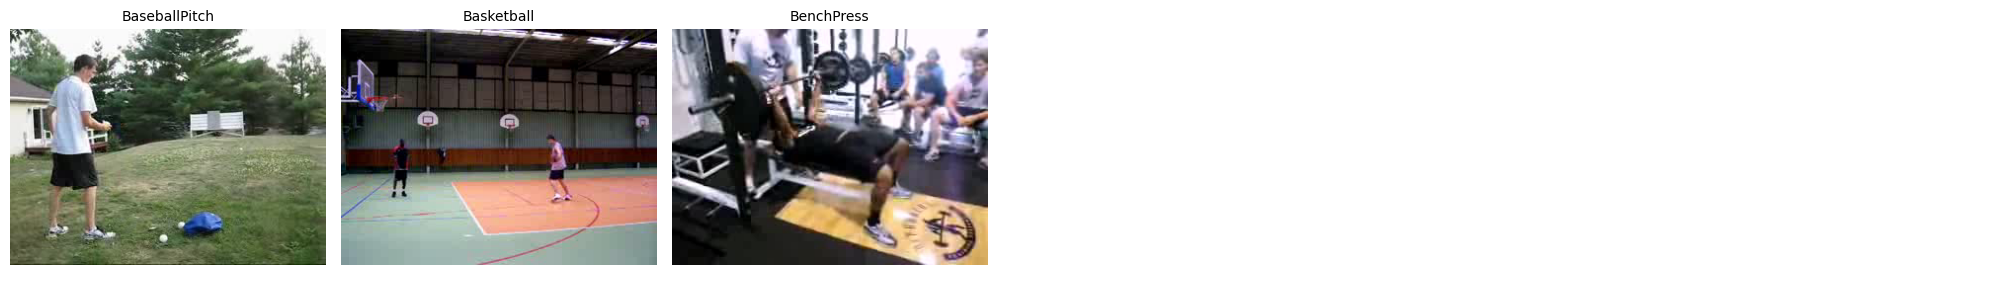

In [5]:
import math

# Calculate grid dimensions
num_classes = len(all_classes)
cols = 6  # Number of columns in the grid
rows = math.ceil(num_classes / cols)

# Create figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each class
for idx, class_name in enumerate(all_classes):
    all_video_files = glob.glob(os.path.join('data', class_name, '*.avi'))
    if len(all_video_files) > 0:
        sample_video_file = all_video_files[0]
        video_reader = cv2.VideoCapture(sample_video_file)
        success, frame = video_reader.read() # Read the first frame
        
        if success:
            axes[idx].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(class_name, fontsize=10)
            axes[idx].axis('off')
        
        video_reader.release() # Release the video reader, meaning close the file

# Hide any unused subplots
for idx in range(num_classes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [6]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

SEQUENCE_LENGTH = 20 #number of frames per video sample

DATASET_PATH = Path('data')
NUM_CLASSES = len(os.listdir(DATASET_PATH))

In [7]:
import numpy as np

def frames_extraction(video_path):
    frames_list=[]
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, video_frames_count // SEQUENCE_LENGTH)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * frame_interval)
        success, frame = video_reader.read()
        
        if success:
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            frame=frame / 255.0  # Normalize pixel values
            frames_list.append(frame)
    video_reader.release()
    return np.array(frames_list)
    

### Step-by-Step Explanation
**Create empty list**

```python
frames_list = []
```

* Stores the processed frames.

---

**Open the video**

```python
video_reader = cv2.VideoCapture(video_path)
```

* Loads the video file so frames can be read.

---

**Count total frames**

```python
video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
```

* Finds how many frames exist in the video.

---

**Decide how many frames to skip**

```python
skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
```

* Ensures frames are sampled **evenly across the entire video**.
* Prevents using only the start of the video.

📌 Example:
If video has 300 frames and `SEQUENCE_LENGTH = 30`
→ every **10th frame** is taken.

---

**Loop to extract frames**

```python
for frame_counter in range(SEQUENCE_LENGTH):
```

* Extracts a **fixed number of frames**.

---

**Jump to the correct frame**

```python
video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
```

* Skips frames to reach the next sampled frame.

---

**Read the frame**

```python
success, frame = video_reader.read()
```

* Reads the selected frame from the video.

---

**Stop if frame read fails**

```python
if not success:
    break
```

* Prevents errors if video ends early.

---

 **Resize the frame**

```python
resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
```

* Makes all frames the **same size** (required for neural networks).

---

**Normalize pixel values**

```python
normalized_frame = resized_frame / 255
```

* Converts pixel range from **0–255 → 0–1**
* Helps the model train faster and more stably.

---

**Store the frame**

```python
frames_list.append(normalized_frame)
```

* Adds processed frame to the list.

---

**Release video memory**

```python
video_reader.release()
```

* Frees system resources.

---

### Final Output

```python
return frames_list
```

* Returns a list of **uniformly sampled, resized, normalized frames**
* Ready for CNN / LSTM / 3D-CNN input

In [8]:
def create_dataset():
    video_paths = []
    labels = []
    features = []
    for class_index, class_name in enumerate(all_classes):
        # for class_index, class_name in tqdm(enumerate(os.listdir(DATASET_PATH))):
        files_list = os.listdir(os.path.join(DATASET_PATH, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_PATH, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                video_paths.append(video_file_path)
                labels.append(class_index)
                features.append(frames)

    features = np.array(features)
    labels = np.array(labels)

    # Return order matches downstream unpacking: features, labels, paths.
    return features, labels, video_paths

In [9]:
features, labels, video_paths = create_dataset()

In [10]:
import tensorflow as tf
from keras.utils import to_categorical

oh_encoded_labels=to_categorical(labels)
oh_encoded_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], shape=(447, 3))

In [11]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, oh_encoded_labels, test_size=0.2, random_state=42,shuffle=True)

In [12]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), recurrent_dropout=0.2, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', recurrent_dropout=0.2, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', recurrent_dropout=0.2, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(all_classes), activation='softmax'))


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 62, 62, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 62, 62, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 29, 29, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 29, 29, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 14, 14, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 12, 12, 16)     │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,363 (2.32 MB)

 Trainable params: 609,307 (2.32 MB)

 Non-trainable params: 56 (224.00 B)

In [14]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(features_train, labels_train, validation_data=(features_test, labels_test), epochs=50, batch_size=8, callbacks=[early_stopping_callback])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.4342 - loss: 1.8898 - val_accuracy: 0.2222 - val_loss: 1.2342
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 405ms/step - accuracy: 0.5966 - loss: 1.5184 - val_accuracy: 0.2222 - val_loss: 1.2280
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - accuracy: 0.6106 - loss: 1.3356 - val_accuracy: 0.4667 - val_loss: 1.0544
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 395ms/step - accuracy: 0.7003 - loss: 0.8866 - val_accuracy: 0.4889 - val_loss: 1.1096
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 428ms/step - accuracy: 0.7731 - loss: 0.9037 - val_accuracy: 0.3889 - val_loss: 1.6635
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 428ms/step - accuracy: 0.7535 - loss: 0.9577 - val_accuracy: 0.4556 - val_loss: 1.5984
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.7759 - loss: 0.7322 - val_accuracy: 0.3889 - val_loss: 3.2489
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.7899 - loss: 0.7175 - val_accu

In [15]:
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, LSTM, Dense

def create_LRCN_model():
    
    model= Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(32))
    
    model.add(Dense(len(all_classes), activation='softmax'))
    
    model.summary()
    return model

In [16]:
lrcnn_model=create_LRCN_model()
lrcnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_lrcnn = lrcnn_model.fit(features_train, labels_train, validation_data=(features_test, labels_test), epochs=50, batch_size=8, callbacks=[early_stopping_callback])


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 62, 62, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 29, 29, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 12, 12, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │       299,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,819 (1.23 MB)

 Trainable params: 322,819 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 311ms/step - accuracy: 0.4510 - loss: 1.0902 - val_accuracy: 0.5000 - val_loss: 0.9622
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.7311 - loss: 0.6358 - val_accuracy: 0.7889 - val_loss: 0.5205
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step - accuracy: 0.8263 - loss: 0.4395 - val_accuracy: 0.8000 - val_loss: 0.4471
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.9048 - loss: 0.3083 - val_accuracy: 0.9444 - val_loss: 0.2065
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.9132 - loss: 0.2662 - val_accuracy: 0.9111 - val_loss: 0.2281
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step - accuracy: 0.9300 - loss: 0.1882 - val_accuracy: 0.9000 - val_loss: 0.2150
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.9608 - loss: 0.1360 - val_accuracy: 0.8889 - val_loss: 0.2730
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 338ms/step - accuracy: 0.9888 - loss: 0.0676 - val_accu

In [17]:
def predict(file_path, model):
    frames = frames_extraction(file_path)
    if len(frames) != SEQUENCE_LENGTH:
        print(f"Video at {file_path} does not have enough frames.")
        return None
    
    input_data = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(input_data)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = all_classes[predicted_class_index]
    
    return predicted_class_name

In [22]:
predicted_class = predict("E:\\70 Days 70 Project\\Human Activity Recognition\\data\\Basketball\\v_Basketball_g01_c01.avi", lrcnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [23]:
predicted_class

'Basketball'